In [1]:
#!export PYTHONPATH=$PYTHONPATH:/data1/practical-sose23/castellvi/castellvi_prediction/bids
import os
import sys
sys.path.append('/data1/practical-sose23/castellvi/castellvi_prediction/bids')

In [2]:
from dataset.VerSe import VerSe
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
from modules.DenseNetModule import DenseNet
from utils._prepare_data import DataHandler
from utils.environment_settings import env_settings

import BIDS
from BIDS import BIDS_Global_info, BIDS_Family, NII
import nibabel as nib
import numpy as np
import cv2


import monai
#from monai.networks.utils import eval_mode
from monai.transforms import (
    AddChannel, Compose, LoadImage, RandRotate90, NormalizeIntensity, RandScaleIntensity,
    Resize, ScaleIntensityRange, ToTensor, ScaleIntensity, RandShiftIntensity,CropForeground,
    RandFlip, RandSpatialCrop, ResizeWithPadOrCrop, Spacing, ThresholdIntensity, Orientation
)
from monai.metrics import compute_roc_auc

import torch
from torch import nn

####################################
/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/u/home/

2023-07-17 13:25:04,419 - Created a temporary directory at /tmp/tmp6578sh4h
2023-07-17 13:25:04,421 - Writing /tmp/tmp6578sh4h/_remote_module_non_scriptable.py


In [3]:
from eval import Eval

In [4]:
from types import SimpleNamespace
ckpt_path = '/data1/practical-sose23/castellvi/team_repo/3D-Castellvi-Prediction/experiments/baseline_models/densenet/best_models/version_10/densenet-epoch=09-val_mcc=0.89.ckpt'
version = 0
# Define a parameters class
params = SimpleNamespace(
    model_path=ckpt_path,
    version = 0,
)

evaluator = Eval(params)

In [5]:
model = evaluator.load_model(evaluator.params.model_path)
processor = evaluator.get_processor()
verse_dataset = evaluator.get_verse_dataset(processor, model)
val_subjects =evaluator.get_val_subjects(verse_dataset)
val_subs_joined = evaluator.get_joined_subjects(verse_dataset, val_subjects)

DenseNet loaded with 3 classes, data_size (128, 86, 136) and 1 channel
[!] Unknown format seg-ano in file sub-verse649_dir-sag_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] "template" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] "sacrum" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] Unknown format subreg in file verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano.nii.gz
[!] "verse549" is not a valid key/value pair. Expected "KEY-VALUE" in verse549_CT-iso_seg-ano.nii.gz
[!] Unknown format ce-ar in file sub-tri106_ce-ar.nii.gz
[!] Unknown format ce-pv in file sub-tri066_ce-pv.nii.gz
[!] Unknown format ce-ne in file sub-tri067_ce-ne.nii.gz
[!] Unknown format

In [6]:
model.to('cuda')
model.eval()

DenseNet(
  (network): DenseNet169(
    (features): Sequential(
      (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (layers): Sequential(
            (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
        )
        (d

In [7]:
for i in val_subs_joined:
    sample_record = i
    break

idx = val_subs_joined[sample_record]['non_flip']
input_img = verse_dataset[idx]["target"]
input_img = input_img.unsqueeze(0)
out = model(input_img.cuda())
out = out.squeeze(0)


In [8]:
input_img.shape

torch.Size([1, 1, 128, 86, 136])

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
input_img = input_img.to(device)

In [11]:
def get_layer_names(model):
    layer_names = []
    for name, _ in model.named_parameters():
        # Split the name by '.' and keep the first part
        layer_name = name
        if layer_name not in layer_names:
            layer_names.append(layer_name)
    return layer_names

In [12]:
layer_names = get_layer_names(model)

In [13]:
conv_layers_list = []
for i in range(len(layer_names)):
    layer = layer_names[i]
    if 'conv' not in layer:
        continue
    else:
        conv_layers_list.append(layer)

In [14]:
campp = monai.visualize.GradCAMpp(nn_module = model, target_layers = "network.features.denseblock4.denselayer32.layers.conv2", )
win_size = (128, 86, 136)
print("original feature shape", campp.feature_map_size([1, 1] + list(win_size), device) )
print("upsampled feature shape", [1, 1] + list(win_size), device)

original feature shape torch.Size([1, 1, 4, 2, 4])
upsampled feature shape [1, 1, 128, 86, 136] cuda


In [15]:
campp_result = campp( x= input_img , class_idx=None)

In [16]:
# Overlay Original image and GradCAM heatmap
def superimposed_image_def(camp_results, original_img, alpha = 0.6):
    all_images_slices = []
    all_heatmap_results = []
    for i in range(input_img.shape[-1]):
        original_image_slice= original_img.detach().cpu().numpy()[..., i]
        original_image_slice = original_image_slice[0,0,:,:] 
        
        # Make 1-channel image to 3-channel : To overlay this image with the heatmap (JET colormap = 3-channels)
        original_image_slice = cv2.merge((original_image_slice, original_image_slice, original_image_slice))
        camp_result_slice = camp_results.detach().cpu().numpy()[..., i]
        camp_result_slice = camp_result_slice[0,0,:,:] # Same above
        
        camp_result_slice = np.maximum(camp_result_slice, 0)

        # Convert Class Activation Map to 0 - 255
        camp_result_slice = (camp_result_slice - camp_result_slice.min()) / (
                camp_result_slice.max() - camp_result_slice.min()
        )
        camp_result_slice = np.uint8(255 * camp_result_slice)

        # Convert to Heatmap ---- JET COLORMAP
        camp_result_slice = cv2.applyColorMap(camp_result_slice, cv2.COLORMAP_JET)

        # Superimpose Heatmap on Image Data
        original_image_slice = np.uint8(
            (original_image_slice - original_image_slice.min())
            / (original_image_slice.max() - original_image_slice.min())
            * 255
        )

        superimposed_image =np.uint8(np.uint8(original_image_slice) * alpha + camp_result_slice * (1 - alpha))
        all_images_slices.append(superimposed_image)
        all_heatmap_results.append(camp_result_slice)
        

    return all_images_slices, all_heatmap_results

In [17]:
imposed_img , heatmap = superimposed_image_def(campp_result, input_img)

####################################
/tmp/ipykernel_4157523/514047442.py:27: RuntimeWarning: invalid value encountered in divide
  (original_image_slice - original_image_slice.min())
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_l

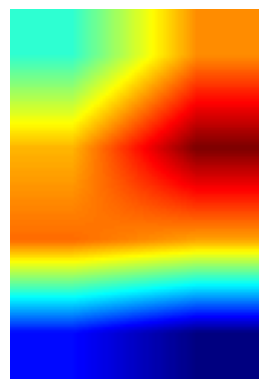

In [18]:
import matplotlib.pyplot as plt

plt.imshow(heatmap[30])
plt.axis('off')  
plt.show()

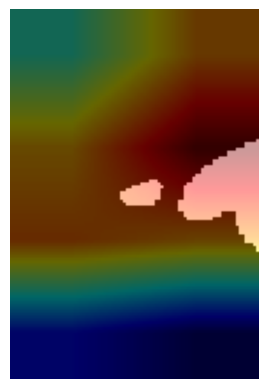

In [19]:
import matplotlib.pyplot as plt

plt.imshow(imposed_img[30])
plt.axis('off')  
plt.show()

In [20]:
from matplotlib import animation, rc

In [21]:
rc('animation', html='jshtml')


def create_animation(array):
    """Create an animation of a volume"""

    fig = plt.figure(figsize=(4, 4))
    images = []
    for idx, image in enumerate(array):
        # plot image without notifying animation
        image_plot = plt.imshow(image, animated=True, cmap='bone')
        aux = [image_plot]
        images.append(aux)

    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.title(f'Deneme', fontsize=16)
    
    ani = animation.ArtistAnimation(
        fig, images, interval=5000//len(array), blit=False, repeat_delay=1000)
    plt.close()
    return ani

In [22]:
create_animation(imposed_img)

2023-07-17 13:26:03,805 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>
